In [ ]:
"""
Performance Analytics Script for Physics Learning System

This notebook provides comprehensive analytics including:
- Time per point over time plots
- Task completion statistics
- Performance trends
- Exam-specific analytics
"""

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from typing import List, Dict, Optional, Tuple
from database.models import DatabaseManager, ExamRepository
from utils.keyboard import get_simple_input
import sqlite3

def format_time(seconds: Optional[int]) -> str:
    """Format seconds into readable time format"""
    if seconds is None:
        return "N/A"
    
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    
    if hours > 0:
        return f"{hours}h {minutes}m {secs}s"
    elif minutes > 0:
        return f"{minutes}m {secs}s"
    else:
        return f"{secs}s"

class PerformanceAnalyzer:
    def __init__(self, db_manager: DatabaseManager):
        self.db_manager = db_manager
        self.exam_id = None
        self.exam_name = "All Exams"
    
    def set_exam(self, exam_id: int, exam_name: str):
        """Set the exam to analyze"""
        self.exam_id = exam_id
        self.exam_name = exam_name
    
    def get_time_per_point_data(self) -> List[Dict]:
        """Get time per point data over time"""
        conn = self.db_manager.get_connection()
        cursor = conn.cursor()
        
        query = '''
            SELECT 
                sa.attempt_date,
                sa.total_time_seconds,
                t.total_points,
                t.task_number,
                w.semester,
                w.sheet_number,
                sa.created_at,
                CAST(sa.total_time_seconds AS FLOAT) / t.total_points as time_per_point
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE sa.status = 'completed' 
            AND sa.total_time_seconds IS NOT NULL 
            AND t.total_points > 0
        '''
        
        params = []
        if self.exam_id:
            query += ' AND w.exam_id = ?'
            params.append(self.exam_id)
        
        query += ' ORDER BY sa.created_at'
        
        cursor.execute(query, params)
        results = cursor.fetchall()
        conn.close()
        
        data = []
        for row in results:
            data.append({
                'attempt_date': row[0],
                'total_time_seconds': row[1],
                'total_points': row[2],
                'task_number': row[3],
                'semester': row[4],
                'sheet_number': row[5],
                'created_at': row[6],
                'time_per_point': row[7]
            })
        
        return data
    
    def get_completion_statistics(self) -> Dict:
        """Get comprehensive completion statistics"""
        conn = self.db_manager.get_connection()
        cursor = conn.cursor()
        
        # Base query conditions
        exam_condition = ""
        params = []
        if self.exam_id:
            exam_condition = "AND w.exam_id = ?"
            params = [self.exam_id]
        
        # Total tasks and points
        cursor.execute(f'''
            SELECT 
                COUNT(DISTINCT t.id) as total_tasks,
                SUM(t.total_points) as total_points
            FROM tasks t
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE 1=1 {exam_condition}
        ''', params)
        total_stats = cursor.fetchone()
        total_tasks = total_stats[0] or 0
        total_points = total_stats[1] or 0
        
        # Tasks done at least once
        cursor.execute(f'''
            SELECT COUNT(DISTINCT t.id) as tasks_done_once
            FROM tasks t
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE t.times_done > 0 {exam_condition}
        ''', params)
        tasks_done_once = cursor.fetchone()[0] or 0
        
        # Points from tasks done at least once
        cursor.execute(f'''
            SELECT SUM(t.total_points) as points_done_once
            FROM tasks t
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE t.times_done > 0 {exam_condition}
        ''', params)
        points_done_once = cursor.fetchone()[0] or 0
        
        # Completion attempts statistics
        cursor.execute(f'''
            SELECT 
                COUNT(*) as total_attempts,
                COUNT(CASE WHEN sa.status = 'completed' THEN 1 END) as completed_attempts,
                COUNT(CASE WHEN sa.status = 'cancelled' THEN 1 END) as cancelled_attempts,
                SUM(CASE WHEN sa.status = 'completed' THEN sa.total_time_seconds END) as total_time_spent
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE 1=1 {exam_condition}
        ''', params)
        attempt_stats = cursor.fetchone()
        
        # Average times by point range
        cursor.execute(f'''
            SELECT 
                CASE 
                    WHEN t.total_points <= 5 THEN '1-5 points'
                    WHEN t.total_points <= 10 THEN '6-10 points'
                    WHEN t.total_points <= 15 THEN '11-15 points'
                    ELSE '16+ points'
                END as point_range,
                COUNT(*) as attempts,
                AVG(sa.total_time_seconds) as avg_time,
                AVG(CAST(sa.total_time_seconds AS FLOAT) / t.total_points) as avg_time_per_point
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE sa.status = 'completed' 
            AND sa.total_time_seconds IS NOT NULL 
            AND t.total_points > 0 {exam_condition}
            GROUP BY point_range
            ORDER BY MIN(t.total_points)
        ''', params)
        point_range_stats = cursor.fetchall()
        
        # Most and least efficient tasks (time per point)
        cursor.execute(f'''
            SELECT 
                PRINTF('S%dB%dA%s', w.semester, w.sheet_number, t.task_number) as task_info,
                t.total_points,
                COUNT(*) as attempts,
                AVG(CAST(sa.total_time_seconds AS FLOAT) / t.total_points) as avg_time_per_point,
                MIN(CAST(sa.total_time_seconds AS FLOAT) / t.total_points) as best_time_per_point,
                MAX(CAST(sa.total_time_seconds AS FLOAT) / t.total_points) as worst_time_per_point
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE sa.status = 'completed' 
            AND sa.total_time_seconds IS NOT NULL 
            AND t.total_points > 0 {exam_condition}
            GROUP BY t.id
            HAVING COUNT(*) >= 1
            ORDER BY avg_time_per_point
        ''', params)
        efficiency_stats = cursor.fetchall()
        
        # Weekly progress (last 8 weeks)
        cursor.execute(f'''
            SELECT 
                DATE(sa.created_at, 'weekday 0', '-6 days') as week_start,
                COUNT(CASE WHEN sa.status = 'completed' THEN 1 END) as completed_tasks,
                SUM(CASE WHEN sa.status = 'completed' THEN sa.total_time_seconds END) as total_time,
                COUNT(DISTINCT t.id) as unique_tasks
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE sa.created_at >= DATE('now', '-8 weeks') {exam_condition}
            GROUP BY week_start
            ORDER BY week_start
        ''', params)
        weekly_stats = cursor.fetchall()
        
        conn.close()
        
        return {
            'total_tasks': total_tasks,
            'total_points': total_points,
            'tasks_done_once': tasks_done_once,
            'points_done_once': points_done_once,
            'task_completion_percentage': (tasks_done_once / total_tasks * 100) if total_tasks > 0 else 0,
            'point_completion_percentage': (points_done_once / total_points * 100) if total_points > 0 else 0,
            'total_attempts': attempt_stats[0] or 0,
            'completed_attempts': attempt_stats[1] or 0,
            'cancelled_attempts': attempt_stats[2] or 0,
            'total_time_spent': attempt_stats[3] or 0,
            'success_rate': (attempt_stats[1] / attempt_stats[0] * 100) if attempt_stats[0] > 0 else 0,
            'point_range_stats': point_range_stats,
            'efficiency_stats': efficiency_stats,
            'weekly_stats': weekly_stats
        }
    
    def plot_time_per_point_over_time(self, data: List[Dict]):
        """Create a plot showing time per point over time"""
        if not data:
            print("❌ No data available for plotting")
            return
        
        # Convert dates and prepare data
        dates = []
        times_per_point = []
        point_sizes = []
        
        for entry in data:
            try:
                # Parse the created_at timestamp
                date_obj = datetime.strptime(entry['created_at'], '%Y-%m-%d %H:%M:%S')
                dates.append(date_obj)
                times_per_point.append(entry['time_per_point'])
                # Size points based on total points (for visual emphasis)
                point_sizes.append(entry['total_points'] * 10)
            except (ValueError, TypeError):
                continue
        
        if not dates:
            print("❌ No valid date data for plotting")
            return
        
        # Create the plot
        plt.figure(figsize=(14, 8))
        
        # Main scatter plot
        scatter = plt.scatter(dates, times_per_point, s=point_sizes, alpha=0.6, c=times_per_point, 
                            cmap='RdYlBu_r', edgecolors='black', linewidth=0.5)
        
        # Add trend line
        if len(dates) > 1:
            # Convert dates to numbers for trend calculation
            date_nums = [mdates.date2num(date) for date in dates]
            z = np.polyfit(date_nums, times_per_point, 1)
            p = np.poly1d(z)
            plt.plot(dates, p(date_nums), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.2f} sec/point per day)')
        
        # Formatting
        plt.title(f'Time per Point Over Time - {self.exam_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Time per Point (seconds)', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        plt.xticks(rotation=45)
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Time per Point (seconds)', rotation=270, labelpad=20)
        
        # Add legend
        plt.legend()
        
        # Add statistics text
        avg_time_per_point = np.mean(times_per_point)
        median_time_per_point = np.median(times_per_point)
        std_time_per_point = np.std(times_per_point)
        
        stats_text = f'Avg: {avg_time_per_point:.1f}s/pt\nMedian: {median_time_per_point:.1f}s/pt\nStd: {std_time_per_point:.1f}s/pt'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    def plot_weekly_progress(self, weekly_stats: List[Tuple]):
        """Plot weekly progress over time"""
        if not weekly_stats:
            print("❌ No weekly data available for plotting")
            return
        
        weeks = []
        completed_tasks = []
        total_times = []
        unique_tasks = []
        
        for week_data in weekly_stats:
            try:
                week_start = datetime.strptime(week_data[0], '%Y-%m-%d')
                weeks.append(week_start)
                completed_tasks.append(week_data[1] or 0)
                total_times.append((week_data[2] or 0) / 3600)  # Convert to hours
                unique_tasks.append(week_data[3] or 0)
            except (ValueError, TypeError):
                continue
        
        if not weeks:
            print("❌ No valid weekly data for plotting")
            return
        
        # Create subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Completed tasks per week
        ax1.bar(weeks, completed_tasks, alpha=0.7, color='skyblue', edgecolor='navy')
        ax1.set_title(f'Weekly Completed Tasks - {self.exam_name}', fontweight='bold')
        ax1.set_ylabel('Completed Tasks')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Time spent per week
        ax2.bar(weeks, total_times, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        ax2.set_title('Weekly Time Spent (Hours)', fontweight='bold')
        ax2.set_ylabel('Hours')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Unique tasks per week
        ax3.bar(weeks, unique_tasks, alpha=0.7, color='salmon', edgecolor='darkred')
        ax3.set_title('Weekly Unique Tasks Attempted', fontweight='bold')
        ax3.set_ylabel('Unique Tasks')
        ax3.set_xlabel('Week Starting')
        ax3.grid(True, alpha=0.3)
        
        # Format x-axis for all plots
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()

    def get_daily_time_data(self) -> List[Dict]:
        """Get daily time spent data"""
        conn = self.db_manager.get_connection()
        cursor = conn.cursor()
        
        query = '''
            SELECT 
                DATE(sa.created_at) as study_date,
                SUM(sa.total_time_seconds) as total_time_seconds,
                COUNT(CASE WHEN sa.status = 'completed' THEN 1 END) as completed_tasks,
                COUNT(*) as total_attempts,
                COUNT(DISTINCT t.id) as unique_tasks
            FROM solution_attempts sa
            JOIN tasks t ON sa.task_id = t.id
            JOIN worksheets w ON t.worksheet_id = w.id
            WHERE sa.total_time_seconds IS NOT NULL
        '''
        
        params = []
        if self.exam_id:
            query += ' AND w.exam_id = ?'
            params.append(self.exam_id)
        
        query += '''
            GROUP BY DATE(sa.created_at)
            HAVING total_time_seconds > 0
            ORDER BY study_date
        '''
        
        cursor.execute(query, params)
        results = cursor.fetchall()
        conn.close()
        
        data = []
        for row in results:
            data.append({
                'study_date': row[0],
                'total_time_seconds': row[1] or 0,
                'completed_tasks': row[2] or 0,
                'total_attempts': row[3] or 0,
                'unique_tasks': row[4] or 0,
                'total_time_hours': (row[1] or 0) / 3600
            })
        
        return data

    def plot_daily_time_spent(self, daily_data: List[Dict]):
        """Plot daily time spent on tasks"""
        if not daily_data:
            print("❌ No daily data available for plotting")
            return
        
        # Prepare data
        dates = []
        daily_hours = []
        completed_tasks = []
        
        for entry in daily_data:
            try:
                date_obj = datetime.strptime(entry['study_date'], '%Y-%m-%d')
                dates.append(date_obj)
                daily_hours.append(entry['total_time_hours'])
                completed_tasks.append(entry['completed_tasks'])
            except (ValueError, TypeError):
                continue
        
        if not dates:
            print("❌ No valid daily data for plotting")
            return
        
        # Create the plot with dual y-axis
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot time spent as bars
        bars = ax1.bar(dates, daily_hours, alpha=0.7, color='skyblue', 
                    edgecolor='navy', linewidth=0.5, label='Time Spent (hours)')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Time Spent (hours)', color='navy', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='navy')
        
        # Add second y-axis for task count
        ax2 = ax1.twinx()
        line = ax2.plot(dates, completed_tasks, color='red', marker='o', 
                    linewidth=2, markersize=4, alpha=0.8, label='Completed Tasks')
        ax2.set_ylabel('Completed Tasks', color='red', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Formatting
        plt.title(f'Daily Time Spent and Tasks Completed - {self.exam_name}', 
                fontsize=16, fontweight='bold')
        
        # Format x-axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(dates)//20)))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Add grid
        ax1.grid(True, alpha=0.3)
        
        # Add statistics
        total_hours = sum(daily_hours)
        total_days = len(daily_hours)
        avg_hours_per_day = total_hours / total_days if total_days > 0 else 0
        max_hours = max(daily_hours) if daily_hours else 0
        total_tasks_completed = sum(completed_tasks)
        
        stats_text = (f'Total Days: {total_days}\n'
                    f'Total Time: {total_hours:.1f}h\n'
                    f'Avg/Day: {avg_hours_per_day:.1f}h\n'
                    f'Max Day: {max_hours:.1f}h\n'
                    f'Total Tasks: {total_tasks_completed}')
        
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Add moving average line if there are enough data points
        if len(daily_hours) >= 7:
            # Calculate 7-day moving average
            ma_dates = []
            ma_hours = []
            for i in range(6, len(daily_hours)):
                ma_dates.append(dates[i])
                ma_hours.append(np.mean(daily_hours[i-6:i+1]))
            
            ax1.plot(ma_dates, ma_hours, color='orange', linewidth=2, 
                    alpha=0.8, label='7-day Moving Avg')
        
        # Create combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    def print_detailed_statistics(self, stats: Dict):
        """Print comprehensive statistics"""
        print(f"\n📊 Detailed Statistics for {self.exam_name}")
        print("=" * 60)
        
        # Overall completion stats
        print(f"\n🎯 Overall Progress:")
        print(f"   Total Tasks Available: {stats['total_tasks']}")
        print(f"   Total Points Available: {stats['total_points']}")
        print(f"   Tasks Done At Least Once: {stats['tasks_done_once']} ({stats['task_completion_percentage']:.1f}%)")
        print(f"   Points Done At Least Once: {stats['points_done_once']} ({stats['point_completion_percentage']:.1f}%)")
        
        # Attempt statistics
        print(f"\n📈 Attempt Statistics:")
        print(f"   Total Attempts: {stats['total_attempts']}")
        print(f"   Completed Attempts: {stats['completed_attempts']}")
        print(f"   Cancelled Attempts: {stats['cancelled_attempts']}")
        print(f"   Success Rate: {stats['success_rate']:.1f}%")
        print(f"   Total Time Spent: {format_time(stats['total_time_spent'])}")
        
        # Average time by point range
        if stats['point_range_stats']:
            print(f"\n⏱️  Performance by Point Range:")
            for point_range, attempts, avg_time, avg_time_per_point in stats['point_range_stats']:
                print(f"   {point_range:<12}: {attempts:>3} attempts, "
                      f"avg {format_time(int(avg_time) if avg_time else 0)}, "
                      f"{avg_time_per_point:.1f}s/point")
        
        # Most and least efficient tasks
        if stats['efficiency_stats']:
            print(f"\n🏆 Most Efficient Tasks (lowest time/point):")
            for i, (task_info, points, attempts, avg_tpp, best_tpp, worst_tpp) in enumerate(stats['efficiency_stats'][:5], 1):
                print(f"   {i}. {task_info} ({points}pts): {avg_tpp:.1f}s/pt avg ({attempts} attempts)")
            
            if len(stats['efficiency_stats']) > 5:
                print(f"\n🐌 Least Efficient Tasks (highest time/point):")
                for i, (task_info, points, attempts, avg_tpp, best_tpp, worst_tpp) in enumerate(stats['efficiency_stats'][-5:], 1):
                    print(f"   {i}. {task_info} ({points}pts): {avg_tpp:.1f}s/pt avg ({attempts} attempts)")
        
        # Weekly summary
        if stats['weekly_stats']:
            print(f"\n📅 Recent Weekly Activity:")
            total_weekly_tasks = sum(week[1] or 0 for week in stats['weekly_stats'])
            total_weekly_time = sum(week[2] or 0 for week in stats['weekly_stats'])
            print(f"   Last {len(stats['weekly_stats'])} weeks: {total_weekly_tasks} tasks completed")
            print(f"   Total time: {format_time(total_weekly_time)}")
            if len(stats['weekly_stats']) > 0:
                avg_weekly_tasks = total_weekly_tasks / len(stats['weekly_stats'])
                print(f"   Average per week: {avg_weekly_tasks:.1f} tasks")


def select_exam_for_analysis(db_manager: DatabaseManager) -> Tuple[Optional[int], str]:
    """Allow user to select an exam for analysis"""
    exam_repo = ExamRepository(db_manager)
    exams = exam_repo.list_exams()
    
    if not exams:
        print("❌ No exams found!")
        return None, "No Exams"
    
    print("\n📋 Available Exams for Analysis:")
    print("0. All Exams (combined analysis)")
    for i, exam in enumerate(exams, 1):
        print(f"{i}. {exam['name']} ({exam['task_count']} tasks)")
    
    while True:
        try:
            choice = int(get_simple_input("\nSelect exam (number): ").strip())
            if choice == 0:
                return None, "All Exams"
            elif 1 <= choice <= len(exams):
                selected_exam = exams[choice - 1]
                return selected_exam['id'], selected_exam['name']
            else:
                print(f"❌ Please enter a number between 0 and {len(exams)}")
        except ValueError:
            print("❌ Please enter a valid number")

In [7]:
# Initialize database
db_manager = DatabaseManager()
db_manager.init_database()

# Select exam for analysis
exam_id, exam_name = select_exam_for_analysis(db_manager)

analyzer = PerformanceAnalyzer(db_manager)
if exam_id:
    analyzer.set_exam(exam_id, exam_name)

print(f"\n✅ Analyzing data for: {exam_name}")


📋 Available Exams for Analysis:
0. All Exams (combined analysis)
1. ExPhys1&2-25 (103 tasks)

✅ Analyzing data for: ExPhys1&2-25


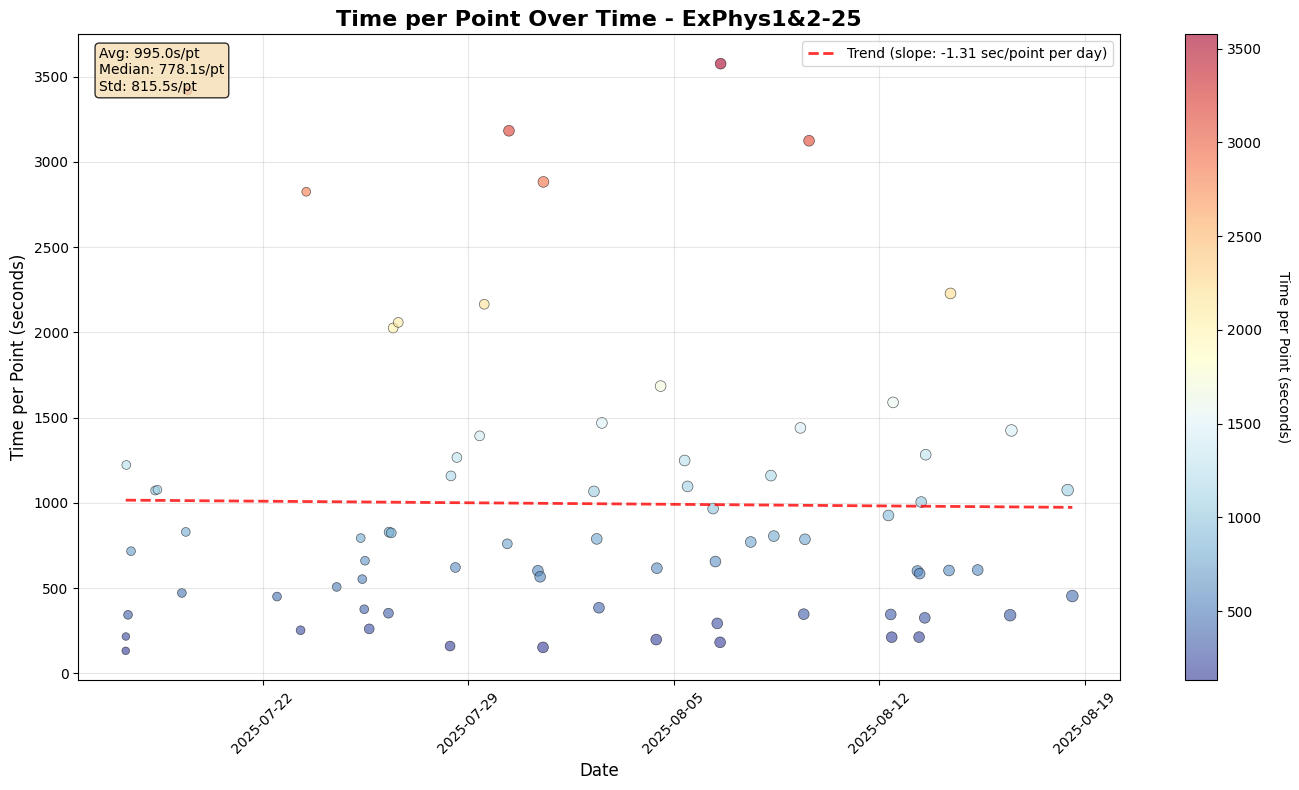

In [8]:
data = analyzer.get_time_per_point_data()
analyzer.plot_time_per_point_over_time(data)

In [9]:
stats = analyzer.get_completion_statistics()
analyzer.print_detailed_statistics(stats)


📊 Detailed Statistics for ExPhys1&2-25

🎯 Overall Progress:
   Total Tasks Available: 103
   Total Points Available: 644
   Tasks Done At Least Once: 73 (70.9%)
   Points Done At Least Once: 393 (61.0%)

📈 Attempt Statistics:
   Total Attempts: 78
   Completed Attempts: 74
   Cancelled Attempts: 4
   Success Rate: 94.9%
   Total Time Spent: 110h 50m 41s

⏱️  Performance by Point Range:
   1-5 points  :  31 attempts, avg 1h 11m 18s, 960.7s/point
   6-10 points :  43 attempts, avg 1h 43m 15s, 1019.8s/point

🏆 Most Efficient Tasks (lowest time/point):
   1. S2B3A3.1 (3pts): 131.7s/pt avg (1 attempts)
   2. S1B9A9.2 (6pts): 151.8s/pt avg (1 attempts)
   3. S1B7A7.1 (5pts): 159.6s/pt avg (1 attempts)
   4. S2B9A9.3 (6pts): 181.5s/pt avg (1 attempts)
   5. S1B11A11.4 (6pts): 197.5s/pt avg (1 attempts)

🐌 Least Efficient Tasks (highest time/point):
   1. S1B6A6.3 (6pts): 2882.8s/pt avg (1 attempts)
   2. S1B2A2.5 (6pts): 3124.3s/pt avg (1 attempts)
   3. S2B11A4 (6pts): 3182.8s/pt avg (1 att

In [10]:
stats = analyzer.get_completion_statistics()
analyzer.plot_weekly_progress(stats['weekly_stats'])

❌ No weekly data available for plotting
